In [1]:
### Sample function definition from SimulaQron with Docstrings:
def __init__(self, name, socket_address=None, cqcFile=None, appFile=None, appID=None, pend_messages=False):
    """
    Initialize a connection to the cqc server.

    - **Arguments**
        :param name:        Name of the host.
        :param socket_address: tuple (str, int) of ip and port number.
        :param cqcFile:    Path to cqcFile. If None, '$NETSIM/config/cqcNodes.cfg is used, unless socket_address
        :param appFile:    Path to appFile. If None, '$NETSIM/config/appNodes.cfg is used.
        :param appID:        Application ID. If set to None, defaults to a nonused ID.
        :param pend_messages: True if you want to wait with sending messages to the back end.
                Use flush() to send all pending messages in one go as a sequence to the server
    """

# Setting the values for constants
* inf: as a default distance to nodes
* time_threshold: threshold time for the rebuilding of the quantum link
* original_capacity: original capacity of the quantum link
* Edge: create Edge object of the graph

In [2]:
inf = float('inf')
time_threshold = 10000
original_capacity = 4
rebuild_probability = 0.25
number_of_nodes = 32

In [3]:
# Importing packages
import os, time, random, logging, logging.handlers
from collections import deque, namedtuple
from datetime import datetime

# Setting up logging
logging.basicConfig(filename='dijkstra.log',level=logging.DEBUG,
                    filemode='w')

# The Graph class

In [4]:
# Edge object of a graph
Edge = namedtuple('edge', 'end, capacity')

# Method adding an edge in the graph
def make_edge(start, end, capacity=original_capacity):
    return Edge(start, end, capacity)

def make_backward_edge(start, end, capacity=original_capacity):
    return Edge(end, start, capacity)

In [5]:
class Vertex:
    def __init__(self, vertex):
        self.name = vertex
        self.neighbours = set()

    # Storing the indices of neighbouring vertices
    def add_neighbour(self, neighbour, capacity=original_capacity):
            if neighbour not in self.neighbours:
                self.neighbours.add(Edge(neighbour,capacity))
            else:
                return False
        
    def add_neighbours(self, neighbours):
        for neighbour in neighbours:
            self.add_neighbour(neighbour)
        
    def __repr__(self):
        return str(self.neighbours)


class Graph:
    
    # Check that the arguments are valid
    def __init__(self, edges = None, capacity = None):
        self.Vertices = {}

        if edges is not None:
            wrong_edges = [i for i in edges if len(i) not in [2, 4]]
            if wrong_edges:
                raise ValueError('Wrong edges data: %s', wrong_edges)
            
            # Adding bidirectional links
            for current_edge in edges:

                # Adding onward link
                if(current_edge[0] not in self.Vertices.keys()):
                    self.Vertices[current_edge[0]] = Vertex(current_edge[0])
                
                self.Vertices[current_edge[0]].add_neighbour(current_edge[1], original_capacity)

                # Adding backward link
                if(current_edge[1] not in self.Vertices.keys()):
                    self.Vertices[current_edge[1]] = Vertex(current_edge[1])

                self.Vertices[current_edge[1]].add_neighbour(current_edge[0], original_capacity)

    # Properties of the class
    @property
    def vertices(self):
        return list(self.Vertices.keys())

    @property
    def neighbours(self):
        return self.Vertices

    def add_vertex(self, vertex):
        if isinstance(vertex, Vertex):
            self.Vertices[vertex.name] = vertex.neighbours
            
    def add_vertices(self, vertices):
        for vertex in vertices:
            self.add_vertex(vertex)

In [6]:
# Get current capacity of a specific link
def link_capacity(self, startNode, endNode):

    # Assembling node pairs into a list
    node_pairs = [[startNode, endNode], [endNode, startNode]]
    edges = self.edges[:]
    for this_edge in edges:
        if [this_edge.start, this_edge.end] in node_pairs:
            return this_edge.capacity

# Adds a link to the network specified by a pair of nodes, the capacity
# Assembling node pairs into a list
def add_link(self, startNode, endNode, capacity=original_capacity):

    node_pairs = [[startNode, endNode], [endNode, startNode]]
    edges = self.edges[:]
    for this_edge in edges:
        if [this_edge.start, this_edge.end] in node_pairs:
            self.edges.remove(this_edge)

            #Add bidirectional link
            self.edges.append(Edge(startNode, endNode, capacity))
            self.edges.append(Edge(endNode, startNode, capacity))

def rebuild_link(self, startNode, endNode, capacity=original_capacity):
    sleep(time_threshold)
    self.add_link(startNode, endNode, capacity)
    logging.debug('Link between %s and %s has been rebuilt.', startNode, endNode)

# Remove a link specified by the start and end node
def remove_link(self, startNode, endNode):

    node_pairs = [[startNode, endNode], [endNode, startNode]]
    edges = self.edges[:]
    for this_edge in edges:
        if [this_edge.start, this_edge.end] in node_pairs:

            self.edges.remove(this_edge)
            self.edges.append(make_edge(this_edge.start, this_edge.end,this_edge.capacity-1))

# Processes a source-destination pair of distance one of the current path
# by checking the capacity of the link between the start and the end node
#
# If the capacity is 0, then a probabilistic rebuild approach is used
#
# Returns the elapsed time that was needed to process the particular source-destination pair
def process_step(self, startNode, endNode):

    local_edt = 0
    # If the capacity of the link is 0, then
    # do probabilistic rebuilding
    # 
    # Else: 
    # Consumes a link from the remaining ones
    # Alternatively: add the threshold waiting time for rebuilding

    if self.link_capacity(startNode,endNode) == 0:

        classical_distance = abs(startNode-endNode)
        #print("Start node: ", startNode)
        #print("End node: ", endNode)
        #print(classical_distance)
        for x in range(1,classical_distance + 1):
            #Probabilistic link creation
            while(rebuild_probability*100<random.randint(1,100)):
                local_edt += 1
    else:

        #Remove the link between startNode and endNode
        self.remove_link(startNode,endNode)

        #Incrementing the entanglement delay time
        local_edt += 1

    return local_edt

# Works through a source-destination pair by traversing through the nodes in between and adding the elapsed time
#
# Calls on the process_step method as many times as big the distance between the source and the destination is
def process_path(self, currentPath):

    logging.debug('current path: %s', currentPath)

    #Initializing entanglement delay time
    edt = 0

    #Take the leftmost two nodes out of the deque and get the edt until we are finished
    while True:
        startNode = currentPath.popleft()
        endNode = currentPath.popleft()
        edt += self.process_step(startNode,endNode)
        currentPath.appendleft(endNode)
        if (len(currentPath))==1:     
            return edt

# Method calculating the shortest path Dijkstra algorithm from a given source node to the destination
def dijkstra(self, source, dest):

    #Checking if the given source is existing or not
    #assert source in self.vertices, 'Such source node doesn\'t exist'

    #Running the Initialize-Single-Source procedure
    distances = {vertex: inf for vertex in self.vertices}
    previous_vertices = {
        vertex: None for vertex in self.vertices
    }
    distances[source] = 0
    vertices = self.vertices.copy()

    #picking each vertex out of the min-priority deque
    while vertices:
        current_vertex = min(
            vertices, key=lambda vertex: distances[vertex])
        vertices.remove(current_vertex)

        #Relaxation procedure
        if distances[current_vertex] == inf:
            break
        for neighbour in self.neighbours[current_vertex]:
            alternative_route = distances[current_vertex] + 1
            if alternative_route < distances[neighbour]:
                distances[neighbour] = alternative_route
                previous_vertices[neighbour] = current_vertex

    path, current_vertex = deque(), dest
    while previous_vertices[current_vertex] is not None:
        path.appendleft(current_vertex)
        current_vertex = previous_vertices[current_vertex]
    if path:
        path.appendleft(current_vertex)
    return path

In [7]:
# Generates random source-destination pairs
# The number of source-destination pairs is given by the argument
def gen_rand_pairs(number_of_pairs):
    result = []
    for x in range(number_of_pairs):
        source = random.randint(1,number_of_nodes)
        dest = random.randint(1,number_of_nodes)
        while source == dest:
            dest = random.randint(1,number_of_nodes)
        result += [[source,dest]]
    return result

# Generates source-destination pairs and finds the nodes in between them by calling on the dijkstra method
def initialize_paths(graph, number_of_source_destination_pairs):

    #Generate random pairs of nodes between which we are seeking a path
    randPairs = gen_rand_pairs(number_of_source_destination_pairs)
    #print(randPairs)
    
    #Assemble paths into one deque
    paths = deque()
    for pair in randPairs:
        paths.appendleft(graph.dijkstra(pair[0],pair[1]))
    return paths

# Sending packets based on the generated source destination pairs
# Processes these pairs by calling the process_path method on the next path
# Processes each of the paths stored in the deque and pushes the result edt into a store
def send_packets(graph, paths):

    edt_store = []

    while True:

        #Process the next path in the deque
        currentPath = paths.popleft()
        logging.debug('current method: send_packets')
        edt_store.append(graph.process_path(currentPath))
        if(len(paths)==0):
            return edt_store
        
def main(graph, number_of_source_destination_pairs):
    
    start = time.time()
    path_store = initialize_paths(graph, number_of_source_destination_pairs)
    
    # Storing the distances of the paths
    distance_store = []
    for x in path_store:
        distance_store.append(len(x))
    # Calculating the entanglement delay times
    edts = send_packets(graph, path_store)
    
    
    end = time.time()  
    logging.debug("Total time: %s", (end - start))
    logging.debug(graph.edges)
    return [edts,distance_store]

# Graph definitions

### Graph 1

In [8]:
graph1 = Graph(
    
    #Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    [(x,x+1) for x in range(1,number_of_nodes)] + [(number_of_nodes,1)]
)

#The edges created for the first graph:
#print([(getattr(x, 'start'), getattr(x, 'end')) for x in graph1.edges])

In [9]:
print(graph1.vertices)
print(graph1.neighbours)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
{1: {edge(end=2, capacity=4), edge(end=32, capacity=4)}, 2: {edge(end=3, capacity=4), edge(end=1, capacity=4)}, 3: {edge(end=4, capacity=4), edge(end=2, capacity=4)}, 4: {edge(end=5, capacity=4), edge(end=3, capacity=4)}, 5: {edge(end=6, capacity=4), edge(end=4, capacity=4)}, 6: {edge(end=7, capacity=4), edge(end=5, capacity=4)}, 7: {edge(end=6, capacity=4), edge(end=8, capacity=4)}, 8: {edge(end=7, capacity=4), edge(end=9, capacity=4)}, 9: {edge(end=10, capacity=4), edge(end=8, capacity=4)}, 10: {edge(end=11, capacity=4), edge(end=9, capacity=4)}, 11: {edge(end=12, capacity=4), edge(end=10, capacity=4)}, 12: {edge(end=13, capacity=4), edge(end=11, capacity=4)}, 13: {edge(end=14, capacity=4), edge(end=12, capacity=4)}, 14: {edge(end=15, capacity=4), edge(end=13, capacity=4)}, 15: {edge(end=14, capacity=4), edge(end=16, capacity=4)}, 16: {edge(end=15, capacity=4), edge

### Graph 2

In [10]:
graph2 = Graph(
    
    #Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    [(x,x+1) for x in range(1,number_of_nodes)] + [(number_of_nodes,1)] +

    #Iniating the edges of 1) type: 1->3, 3->5, ... 31->1
    #Odd number of nodes  
    [(x,x+2) for x in range(1,number_of_nodes+1)
             if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1] +
    
    #Even number of nodes
    [(x,(x+2) % number_of_nodes) for x in range(1,number_of_nodes+1) if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 0]
)

#The edges created for the second graph:
#print([(getattr(x, 'start'), getattr(x, 'end')) for x in graph2.edges])

### Graph 3

In [11]:
graph3 = Graph(
    
    #Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    [(x,x+1) for x in range(1,number_of_nodes)] + [(number_of_nodes,1)] +

    #Iniating the edges of 1) type: 1->3, 3->5, ... 31->1
    
    #Even number of nodes
    [(x,(x+2) % number_of_nodes) for x in range(1,number_of_nodes+1)
                                 if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 0] +
        
    #Odd number of nodes  
    [(x,x+2) for x in range(1,number_of_nodes+1)
             if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1] +
        
    #Iniating the edges of 2) type: 1->5, 5->9, ... 29->1
    #Number of nodes have 0 as remainder for modulo 4  
    [(x,
      x+4) for x in range(1,number_of_nodes-3) if x % 4 == 1 and number_of_nodes % 4 == 0] + [(number_of_nodes-3,1) for x in range(1,2) if number_of_nodes % 4 == 0]
    
)

#The edges created for the third graph:
#print([(getattr(x, 'start'), getattr(x, 'end')) for x in graph3.edges])

In [12]:
graph3.vertices

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

In [13]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def loop_main(graph, number):
    avg_edts = []
    for x in range(1, number+1):
        [edts, distances] = main(graph, x)
        avg_edts.append(mean(edts))
    return [avg_edts, distances]

# Define the number of source destination pairs

In [14]:
number_of_sd_pairs = 50
number_of_samples = 10

# Plotting the results

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

### Calculating average edts and distances

In [16]:
#Simulation for more than one run of the loop_main
def do_simulation(graph, sd_pair, samples):
    [local_edts,local_distances] = loop_main(graph, sd_pair)
    
    #Iterating through the remaining simulation rounds
    for x in range(1,samples):
        [next_edts,next_distances] = loop_main(graph, sd_pair)
        
        #Summing up the values obtained in each round
        local_edts = [sum(x) for x in zip(local_edts, next_edts)]
        local_distances = [sum(x) for x in zip(local_distances, next_distances)]
    
    #Returning the average of the result values
    return [[x/samples for x in local_edts],[x/samples for x in local_distances]]

In [32]:
[avg_edts1, distances1] = do_simulation(graph1, number_of_sd_pairs, number_of_samples)
[avg_edts2, distances2] = do_simulation(graph2, number_of_sd_pairs, number_of_samples)
[avg_edts3, distances3] = do_simulation(graph3, number_of_sd_pairs, number_of_samples)

AttributeError: 'Graph' object has no attribute 'dijkstra'

### Plotting the edt results of the three graphs

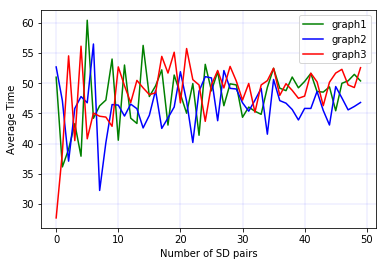

In [19]:
plt.plot(avg_edts1,color='green', label="graph1")
plt.plot(avg_edts2, color='blue', label="graph2")
plt.plot(avg_edts3, color='red', label="graph3")
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.xlabel('Number of SD pairs')
plt.ylabel('Average Time')
plt.legend()
plt.savefig(str(number_of_sd_pairs) + '_sdpairs_' + str(number_of_samples) + '_samples_edt.png')
plt.show()

### Plotting the distances for each number of source-destination pairs

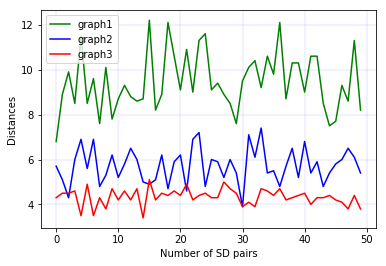

In [20]:
plt.plot(distances1,color='green', label="graph1")
plt.plot(distances2, color='blue', label="graph2")
plt.plot(distances3, color='red', label="graph3")
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.xlabel('Number of SD pairs')
plt.ylabel('Distances')
plt.legend()
plt.savefig(str(number_of_sd_pairs) + '_sdpairs_' + str(number_of_samples) + '_samples_distances.png')
plt.show()

In [33]:
class Vertex:
    def __init__(self, vertex):
        self.name = vertex
        self.neighbors = []
    def add_neighbor(self, neighbor):
        if isinstance(neighbor, Vertex):
            if neighbor.name not in self.neighbors:
                self.neighbors.append(neighbor.name)
                neighbor.neighbors.append(self.name)
                self.neighbors = sorted(self.neighbors)
                neighbor.neighbors = sorted(neighbor.neighbors)
        else:
            return False
        
    def add_neighbors(self, neighbors):
        for neighbor in neighbors:
            self.add_neighbor(neighbor)
        
    def __repr__(self):
        return str(self.neighbors)

class Graph:
    def __init__(self):
        self.vertices = {}
    
    def add_vertex(self, vertex):
        if isinstance(vertex, Vertex):
            self.vertices[vertex.name] = vertex.neighbors

            
    def add_vertices(self, vertices):
        for vertex in vertices:
            self.add_vertex(vertex)
            
    def add_edge(self, vertex_from, vertex_to):
        if isinstance(vertex_from, Vertex) and isinstance(vertex_to, Vertex):
            vertex_from.add_neighbor(vertex_to)
            if isinstance(vertex_from, Vertex) and isinstance(vertex_to, Vertex):
                self.vertices[vertex_from.name] = vertex_from.neighbors
                self.vertices[vertex_to.name] = vertex_to.neighbors
                
    def add_edges(self, edges):
        for edge in edges:
            self.add_edge(edge[0],edge[1])          
    
    def adjacencyList(self):
        if len(self.vertices) >= 1:
                return [str(key) + ":" + str(self.vertices[key]) for key in self.vertices.keys()]  
        else:
            return dict()
        
    def adjacencyMatrix(self):
        if len(self.vertices) >= 1:
            self.vertex_names = sorted(g.vertices.keys())
            self.vertex_indices = dict(zip(self.vertex_names, range(len(self.vertex_names)))) 
            import numpy as np
            self.adjacency_matrix = np.zeros(shape=(len(self.vertices),len(self.vertices)))
            for i in range(len(self.vertex_names)):
                for j in range(i, len(self.vertices)):
                    for el in g.vertices[self.vertex_names[i]]:
                        j = g.vertex_indices[el]
                        self.adjacency_matrix[i,j] = 1
            return self.adjacency_matrix
        else:
            return dict()              
                        

def graph(g):
    """ Function to print a graph as adjacency list and adjacency matrix. """
    return str(g.adjacencyList()) + '\n' + '\n' + str(g.adjacencyMatrix())

###################################################################################

a = Vertex('A')
b = Vertex('B')
c = Vertex('C')
d = Vertex('D')
e = Vertex('E')

a.add_neighbors([b,c,e]) 
b.add_neighbors([a,c])
c.add_neighbors([b,d,a,e])
d.add_neighbor(c)
e.add_neighbors([a,c])
        
        
g = Graph()
print(graph(g))
print("\n")
g.add_vertices([a,b,c,d,e])
g.add_edge(b,d)
print("\n")
print(graph(g))

{}

{}




["A:['B', 'C', 'E']", "B:['A', 'C', 'D']", "C:['A', 'B', 'D', 'E']", "D:['B', 'C']", "E:['A', 'C']"]

[[0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0.]
 [1. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0.]]
